# Linear Regression Health Costs Calculator

In this challenge, you will predict healthcare costs using a regression algorithm.

You are given a dataset that contains information about different people including their healthcare costs. Use the data to predict healthcare costs based on new data.

The first two cells of this notebook import libraries and the data.

Make sure to convert categorical data to numbers. Use 80% of the data as the train_dataset and 20% of the data as the test_dataset.

pop off the "expenses" column from these datasets to create new datasets called train_labels and test_labels. Use these labels when training your model.

Create a model and train it with the train_dataset. Run the final cell in this notebook to check your model. The final cell will use the unseen test_dataset to check how well the model generalizes.

To pass the challenge, model.evaluate must return a Mean Absolute Error of under 3500. This means it predicts health care costs correctly within $3500.

The final cell will also predict expenses using the test_dataset and graph the results.


The first two cells of this notebook import libraries and the data.

In [25]:
# Import libraries. You may or may not use all of these.
#!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

#%pip install git+https://github.com/tensorflow/docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [26]:
# Import data
#!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


### Make sure to convert categorical data to numbers.
### Use 80% of the data as the train_dataset and 20% of the data as the test_dataset.

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [28]:
df.describe()

,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


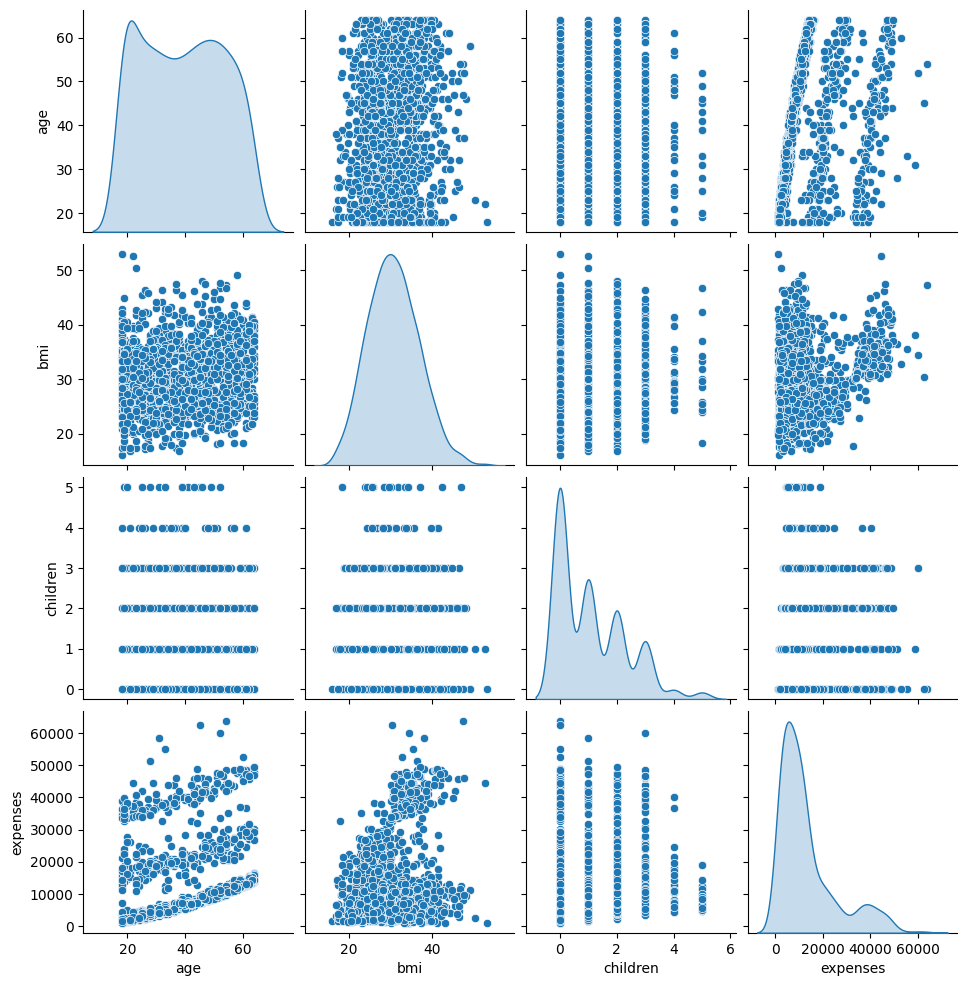

In [29]:
sns.pairplot(df, diag_kind='kde')

#### According to the above observations, let's treat 'sex', 'children', 'smoker' and 'region' as categorical data.
#### So 'age' and 'bmi' are the numerical data, and 'expenses' the label.

In [30]:
# checking possible values for the categorical data
print(df['sex'].unique(), '\n', df['smoker'].unique(), '\n', df['region'].unique())

['female' 'male'] 
 ['yes' 'no'] 
 ['southwest' 'southeast' 'northwest' 'northeast']


In [31]:
# one-hot encoding the categorical data
df_encoded = pd.get_dummies(df, columns=['children', 'sex', 'smoker'], drop_first=True, dtype=int)
df_encoded = pd.get_dummies(df_encoded, columns=['region'], dtype='int8')
df_encoded

,age,bmi,expenses,children_1,children_2,children_3,children_4,children_5,sex_male,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.9,16884.92,0,0,0,0,0,0,1,0,0,0,1
1,18,33.8,1725.55,1,0,0,0,0,1,0,0,0,1,0
2,28,33.0,4449.46,0,0,1,0,0,1,0,0,0,1,0
3,33,22.7,21984.47,0,0,0,0,0,1,0,0,1,0,0
4,32,28.9,3866.86,0,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,31.0,10600.55,0,0,1,0,0,1,0,0,1,0,0
1334,18,31.9,2205.98,0,0,0,0,0,0,0,1,0,0,0
1335,18,36.9,1629.83,0,0,0,0,0,0,0,0,0,1,0
1336,21,25.8,2007.95,0,0,0,0,0,0,0,0,0,0,1


In [32]:
# dividing the dataset: 80% for training, 20% for testing
train_dataset = df_encoded.sample(frac=0.8, random_state=0)
test_dataset = df_encoded.drop(train_dataset.index)

pop off the "expenses" column from these datasets to create new datasets called train_labels and test_labels. Use these labels when training your model.

In [33]:
train_labels = train_dataset.pop('expenses')
test_labels = test_dataset.pop('expenses')

Create a model and train it with the train_dataset.

In [34]:
# normalizing the layers. The one-hot features are also normalized for simplicity
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_dataset))

In [37]:
model = keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

model.compile(loss='mean_absolute_error',
            metrics=['mean_absolute_error', 'mean_squared_error'],
            optimizer='adam')

history = model.fit(
    train_dataset,
    train_labels,
    validation_data=(test_dataset, test_labels),
    verbose=1,
    epochs=200
    )

Epoch 1/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 13369.8369 - mean_absolute_error: 13369.8369 - mean_squared_error: 330276864.0000 - val_loss: 14120.5303 - val_mean_absolute_error: 14120.5303 - val_mean_squared_error: 356256640.0000
Epoch 2/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13462.3535 - mean_absolute_error: 13462.3535 - mean_squared_error: 329594304.0000 - val_loss: 14111.6504 - val_mean_absolute_error: 14111.6504 - val_mean_squared_error: 355996608.0000
Epoch 3/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13183.6826 - mean_absolute_error: 13183.6826 - mean_squared_error: 316345664.0000 - val_loss: 14091.8545 - val_mean_absolute_error: 14091.8545 - val_mean_squared_error: 355419104.0000
Epoch 4/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13308.4424 - mean_absolute_error: 13308.4424 - mean_squared_error: 331688640.0000 - val_loss: 14054.0791 - val_mean_absolute_error: 14054.0791 - val_mean_squared_error: 354319168.0000
Epoch 5/200
34/34 ━━━━━━━━━━

9/9 - 0s - 4ms/step - loss: 3122.1672 - mean_absolute_error: 3122.1672 - mean_squared_error: 41100696.0000
Testing set Mean Abs Error: 3122.17 expenses
You passed the challenge. Great job!
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


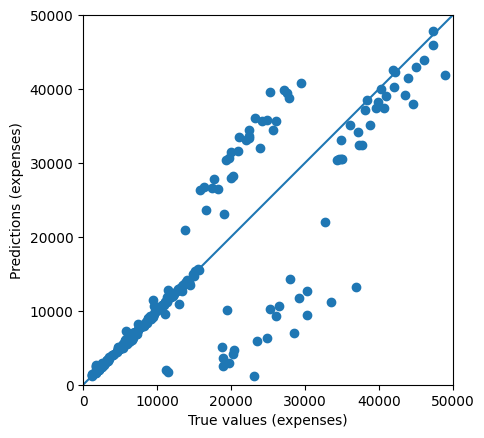

In [38]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)

# This first model already passes the test... but let's try to improve a little...

In [43]:
#function create and train a model according to the paramenters received.
#return the training history
def model_and_fit(num_of_layers, size_of_layers, dropout, epochs):
    # initializing the model
    model = keras.Sequential([normalizer])

    #add dense and dropout layers according to the parameters received
    for _ in range(num_of_layers):
        model.add(layers.Dense(size_of_layers, activation='relu'))
        if dropout:
            model.add(layers.Dropout(dropout))

    #add the final layer
    model.add(layers.Dense(1))

    #compile
    model.compile(loss='mean_absolute_error',
                  metrics=['mean_absolute_error', 'mean_squared_error'],
                  optimizer='adam')
    
    #and train
    history = model.fit(
        train_dataset,
        train_labels,
        validation_data=(test_dataset, test_labels),
        verbose=1,
        epochs=epochs,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50)] #early stop if already stabilized
    )
    #return the trained model and the training history
    return model, history

In [ ]:
#define the parameters that will be tested
possible = {
    'num_of_layers': [1, 3, 5],
    'size_of_layers': [32, 64, 128],
    'dropout': [0, 0.2, 0.5],
    'epochs': [200, 500, 1000]
}

#train a model with every single possible combination of the parameters defined above
#save the results in a dictionary
models = {}
i = 0
for nol in possible["num_of_layers"]:
    for sol in possible["size_of_layers"]:
        for do in possible["dropout"]:
            for e in possible["epochs"]:
                models[i] = {}
                models[i]['params'] = [nol, sol, do, e]
                models[i]['model'], models[i]['history'] = model_and_fit(nol, sol, do, e)
                i += 1

#save the results dictionary in a file for reuse in new session
file = open('P03_hist', 'ab')
pickle.dump(models, file)                    
file.close()

Epoch 1/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 12652.3447 - mean_absolute_error: 12652.3447 - mean_squared_error: 294039648.0000 - val_loss: 14121.5557 - val_mean_absolute_error: 14121.5557 - val_mean_squared_error: 356284224.0000
Epoch 2/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12839.9570 - mean_absolute_error: 12839.9570 - mean_squared_error: 307005472.0000 - val_loss: 14117.3154 - val_mean_absolute_error: 14117.3154 - val_mean_squared_error: 356160864.0000
Epoch 3/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13418.9082 - mean_absolute_error: 13418.9082 - mean_squared_error: 327561152.0000 - val_loss: 14109.0742 - val_mean_absolute_error: 14109.0742 - val_mean_squared_error: 355924128.0000
Epoch 4/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12714.8379 - mean_absolute_error: 12714.8379 - mean_squared_error: 299753888.0000 - val_loss: 14094.8320 - val_mean_absolute_error: 14094.8320 - val_mean_squared_error: 355517472.0000
Epoch 5/200
34/34 ━━━━━━━━━

In [ ]:
# ***ONLY RUN IF RECOVERING FILE FROM A PREVIOUS SESSION!***

'''
file = open('P03_hist', 'rb')
models = pickle.load(file)
models
'''

In [41]:
# 'histories' is a dict containing the results of running the many models defined earlier
# may be generated or recovered from a previous session

#preparing the results for plot

histories = models.keys()
models.values() #dict_values([{'params': [1, 32, 0, 200], 'model': <keras.model>, 'history': <keras.src.callbacks.history.History object at 0x794a1c406300>}, ...])
params = [x['params'] for x in models.values()]
loss = [sum(x['history'].history["loss"][-5:])/5 for x in models.values()] #[10274.632421875, 5252.05654296875, 3151.6744140625, 10147.4548828125, ...]
val_loss = [sum(x['history'].history["val_loss"][-5:])/5 for x in models.values()] #[11382.58515625, 5897.100390625, 3793.431396484375, 11177.532421875, ...]

num_layers = [x[0] for x in params]
size_layers = [x[1] for x in params]
drop = [x[2] for x in params]
ep = [x[3] for x in params]
overfitting = [val_loss[i] - loss[i] for i in range(len(loss))]

results_lists = {
    'models': histories,
    'num_layers': num_layers,
    'size_layers': size_layers,
    'drop': drop,
    'ep': ep,
    'loss': loss,
    'val_loss': val_loss
}
results_lists

{'models': dict_keys([0, 1]),
 'num_layers': [2, 2],
 'size_layers': [32, 32],
 'drop': [0, 0.5],
 'ep': [200, 200],
 'loss': [2827.793310546875, 4588.29130859375],
 'val_loss': [3708.761962890625, 3968.16025390625]}

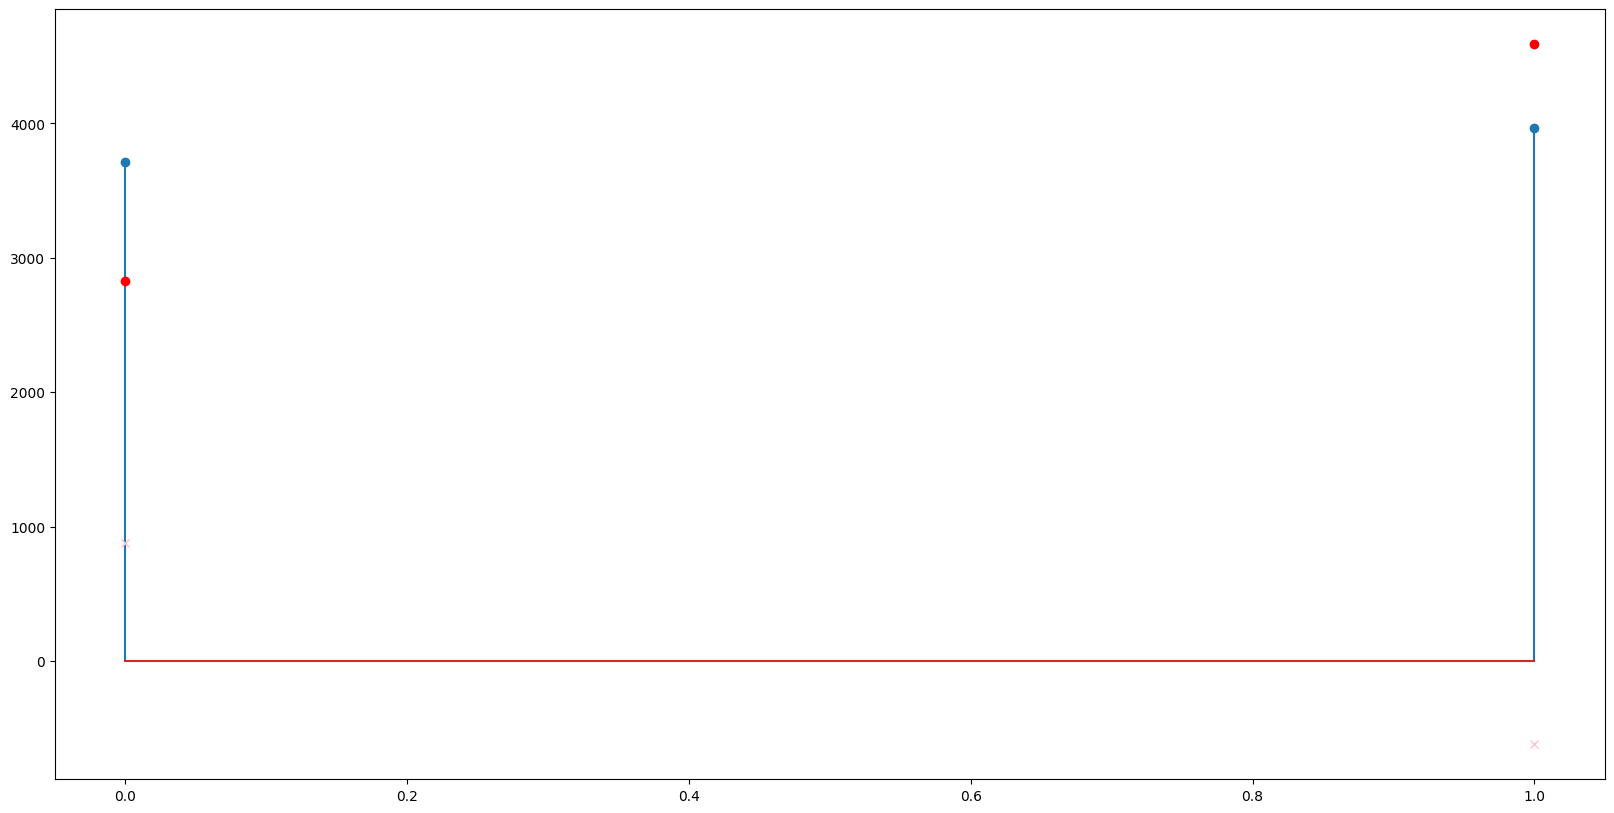

In [42]:
fig, ax = plt.subplots(figsize=(20,10))

ax.stem(histories, val_loss)
ax.plot(histories, loss, 'o', color='red')
ax.plot(histories, overfitting, 'x', color='pink')
ax.annotate('test', (40, 6000))

plt.show()

## Analyzing the above results, the best model (lowest mean average error and no overfitting) is the model ""
### This model gets "" mean average error, compared to ~3100 of the first model

In [ ]:
#update the model to be used on the test with the new best model
model = models[0]['model']

##

Run the final cell in this notebook to check your model. The final cell will use the unseen test_dataset to check how well the model generalizes.

To pass the challenge, model.evaluate must return a Mean Absolute Error of under 3500. This means it predicts health care costs correctly within $3500.

The final cell will also predict expenses using the test_dataset and graph the results.

9/9 - 0s - 4ms/step - loss: 2929.5710 - mean_absolute_error: 2929.5710 - mean_squared_error: 37393104.0000
Testing set Mean Abs Error: 2929.57 expenses
You passed the challenge. Great job!
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


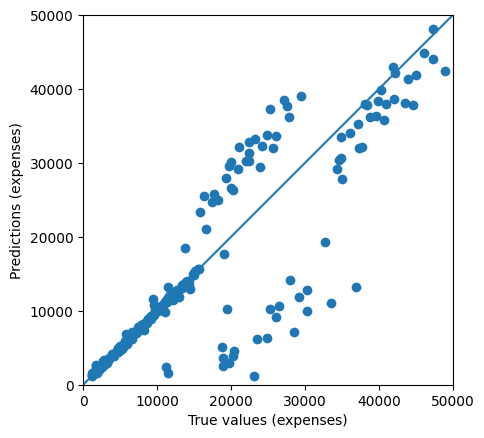

In [118]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
